## Multi-label text classification 
This notebook demonstrates how to solve a multi-label classification problem. 
That is a classification problem where each text can have multiple class labels.
The dataset used for this demonstration is NTCIR-13_MedWeb. For classification this dataset contains 2560 tweets and 8 classes.

In [1]:
# linear algebra
import numpy as np 
from numpy import array
from numpy import asarray
from numpy import zeros

# data processing, CSV file I/O 
import pandas as pd 

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

# Text preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# deep learning model
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


# model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (multilabel_confusion_matrix, 
                             classification_report, 
                             hamming_loss)

import pickle
import sys
import itertools
import warnings
warnings.filterwarnings('ignore')



Using TensorFlow backend.


2.3.1


In [2]:
df1 = pd.read_csv("MedWeb_TestCollection/NTCIR-13_MedWeb_en_training.csv", encoding = "ISO-8859-1")
df2 = pd.read_csv("MedWeb_TestCollection/NTCIR-13_MedWeb_en_test.csv", encoding = "ISO-8859-1")
df = pd.concat([df1, df2])

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)
df1.head()

(2560, 10)


,ID,Tweet,Influenza,Diarrhea,Hayfever,Cough,Headache,Fever,Runnynose,Cold
0,1en,The cold makes my whole body weak.,n,n,n,n,n,n,n,p
1,2en,It's been a while since I've had allergy sympt...,n,n,p,n,n,n,p,n
2,3en,I'm so feverish and out of it because of my al...,n,n,p,n,n,p,p,n
3,4en,"I took some medicine for my runny nose, but it...",n,n,n,n,n,n,p,n
4,5en,I had a bad case of diarrhea when I traveled t...,n,n,n,n,n,n,n,n


In [3]:
df = df.replace(['n'],0)
df = df.replace(['p'],1)
df.head()

,ID,Tweet,Influenza,Diarrhea,Hayfever,Cough,Headache,Fever,Runnynose,Cold
0,1en,The cold makes my whole body weak.,0,0,0,0,0,0,0,1
1,2en,It's been a while since I've had allergy sympt...,0,0,1,0,0,0,1,0
2,3en,I'm so feverish and out of it because of my al...,0,0,1,0,0,1,1,0
3,4en,"I took some medicine for my runny nose, but it...",0,0,0,0,0,0,1,0
4,5en,I had a bad case of diarrhea when I traveled t...,0,0,0,0,0,0,0,0


In [46]:
df.iloc[1].Tweet

'sinc allergi symptom'

## EDA - Exploratory data analysis

In [5]:
# Set size and color for plots
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(4,4)},
    style="darkgrid",
    palette="Set2",
    font_scale=1)

%matplotlib inline

In [6]:
categories = df.iloc[:,2:].columns.values
categories

array(['Influenza', 'Diarrhea', 'Hayfever', 'Cough', 'Headache', 'Fever',
       'Runnynose', 'Cold'], dtype=object)

In [7]:
df_symptom = df.drop(['ID', 'Tweet'], axis=1)
counts = []
for i in list(df_symptom.columns.values):
    counts.append((i, df_symptom[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_tweets'])
df_stats

,category,number_of_tweets
0,Influenza,130
1,Diarrhea,246
2,Hayfever,209
3,Cough,307
4,Headache,328
5,Fever,438
6,Runnynose,498
7,Cold,355


Text(0.5,0,'category')

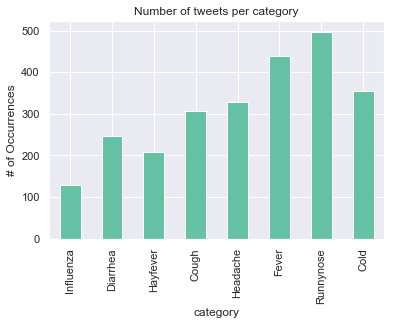

In [8]:
df_stats.plot(x='category', y='number_of_tweets', kind='bar', legend=False)
plt.title("Number of tweets per category")
plt.ylabel('# of Occurrences')
plt.xlabel('category')

Text(0.5,0,'# of categories')

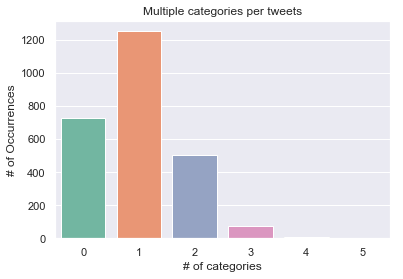

In [9]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per tweets")
plt.ylabel('# of Occurrences')
plt.xlabel('# of categories')

Text(0.5,0,'Document length')

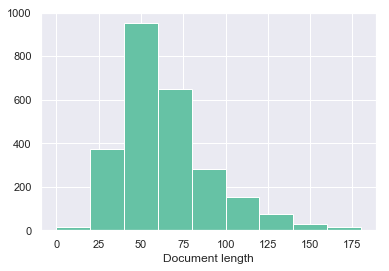

In [10]:
lens = df.Tweet.str.len()
lens.hist(bins = np.arange(0,200,20))
plt.xlabel('Document length')

In [11]:
most_common_cat = pd.DataFrame()
most_common_cat['cat'] = df.columns[2:]
most_common_cat['count'] = df.iloc[:,2:].sum().values
most_common_cat.sort_values(['count'], inplace=True, ascending=False)
most_common_cat.reset_index(inplace=True, drop=True)
most_common_cat.head(len(categories))

,cat,count
0,Runnynose,498
1,Fever,438
2,Cold,355
3,Headache,328
4,Cough,307
5,Diarrhea,246
6,Hayfever,209
7,Influenza,130


In [12]:
# Check the class imbalance problem
most_common_cat['class_weight'] = len(most_common_cat) / most_common_cat['count']
class_weight = {}
for index, label in enumerate(categories):
    class_weight[index] = most_common_cat[most_common_cat['cat'] == label]['class_weight'].values[0]
    
most_common_cat.head()

,cat,count,class_weight
0,Runnynose,498,0.016064
1,Fever,438,0.018265
2,Cold,355,0.022535
3,Headache,328,0.024390
4,Cough,307,0.026059


## Text preprocessing

In [13]:
# Dealing with contractions (e.g., “won't” decontracted to “will not”)
def decontract(sentence):
    # specific
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)

    # general
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

# Remove punctuation (e.g., Comma, Semicolon, and Colon)
def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

# Remove non-alphabetic characters
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

# Remove stop words (e.g., “the”, “a”, “an”, “in”) 
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub("", sentence)

In [14]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

In [15]:
# Reduce a word to its stem or root format (e.g., “started” reduced to “start”) 
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [16]:
df['Tweet'] = df['Tweet'].str.lower()
df['Tweet'] = df['Tweet'].apply(decontract)
df['Tweet'] = df['Tweet'].apply(cleanPunc)
df['Tweet'] = df['Tweet'].apply(keepAlpha)
df['Tweet'] = df['Tweet'].apply(removeStopWords)
df['Tweet'] = df['Tweet'].apply(stemming)
df.head()

,ID,Tweet,Influenza,Diarrhea,Hayfever,Cough,Headache,Fever,Runnynose,Cold
0,1en,cold make whole bodi weak,0,0,0,0,0,0,0,1
1,2en,sinc allergi symptom,0,0,1,0,0,0,1,0
2,3en,feverish allergi sleepi,0,0,1,0,0,1,1,0
3,4en,took medicin runni nose not stop,0,0,0,0,0,0,1,0
4,5en,bad case diarrhea travel nepal,0,0,0,0,0,0,0,0


## Feature extraction

In [17]:
words = list(set(df["Tweet"].values))
num_words = len(words)

maxlen = df.copy()
maxlen['len'] = df.Tweet.apply(lambda x: len(x.split()))
maxlen = maxlen['len'].max()

print(num_words)
print(maxlen)

2483
27


In [18]:
# Transforms each text in texts to a sequence of integers
tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(df['Tweet'])
sequences = tokenizer.texts_to_sequences(df['Tweet'])
x = pad_sequences(sequences, maxlen=maxlen, padding="post")
print(x[0])

[  2  35 301 169  51   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


In [19]:
with open('en-tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# Split arrays into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    df[df.columns[2:]], 
                                                    test_size=0.1, 
                                                    random_state=135)

In [21]:
max_words = len(tokenizer.word_index) + 1
emd_size = 50

In [22]:
# Create the embedding matrix using GloVe, pre-trained word vectors (https://nlp.stanford.edu/projects/glove/)
embeddings_dictionary = dict()
glove_file = open('glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((max_words, emd_size))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Create and train a model

In [23]:
num_classes = len(categories)
batch_size = 32 
epochs = 30

In [24]:
# Create a LSTM model
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(max_words, emd_size, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(num_classes, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

callbacks = [
#     EarlyStopping(),
#     ReduceLROnPlateau(),
    ModelCheckpoint(filepath='en-model-GloVe-LSTM.h5', save_best_only=True)
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])

In [25]:
# Train a model
history = model.fit(X_train, y_train.values,
#                     class_weight=class_weight,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split=0.1,
                    callbacks=callbacks)

Epoch 1/30
65/65 [==============================] - 2s 38ms/step - loss: 0.4082 - auc: 0.5721 - val_loss: 0.3514 - val_auc: 0.5983
Epoch 2/30
65/65 [==============================] - 2s 24ms/step - loss: 0.3657 - auc: 0.6059 - val_loss: 0.3540 - val_auc: 0.6060
Epoch 3/30
65/65 [==============================] - 2s 25ms/step - loss: 0.3491 - auc: 0.6942 - val_loss: 0.3135 - val_auc: 0.7575
Epoch 4/30
65/65 [==============================] - 2s 30ms/step - loss: 0.3202 - auc: 0.7721 - val_loss: 0.3129 - val_auc: 0.7543
Epoch 5/30
65/65 [==============================] - 2s 29ms/step - loss: 0.3119 - auc: 0.7874 - val_loss: 0.3063 - val_auc: 0.7788
Epoch 6/30
65/65 [==============================] - 2s 38ms/step - loss: 0.3093 - auc: 0.7924 - val_loss: 0.3005 - val_auc: 0.7845
Epoch 7/30
65/65 [==============================] - 2s 38ms/step - loss: 0.2949 - auc: 0.8227 - val_loss: 0.2834 - val_auc: 0.8270
Epoch 8/30
65/65 [==============================] - 2s 32ms/step - loss: 0.2735 - a

## Evaluation 

In [26]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

8/8 [==============================] - 0s 9ms/step - loss: 0.1611 - auc: 0.9598
auc: 0.959794819355011


In [27]:
print(history.history.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


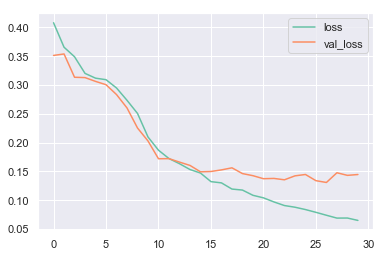

In [28]:
# Plot loss per iteration
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

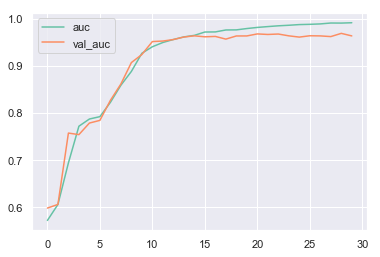

In [29]:
# Plot accuracy per iteration
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.legend()

In [30]:
y_pred = model.predict(X_test)
y_pred = y_pred.round()
y_pred[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [31]:
y_test[:5]

,Influenza,Diarrhea,Hayfever,Cough,Headache,Fever,Runnynose,Cold
547,0,0,0,0,0,0,0,0
334,0,0,0,0,1,0,0,0
2381,0,0,0,1,0,0,0,0
1698,0,0,0,0,0,1,0,0
1663,1,0,0,0,0,1,0,0


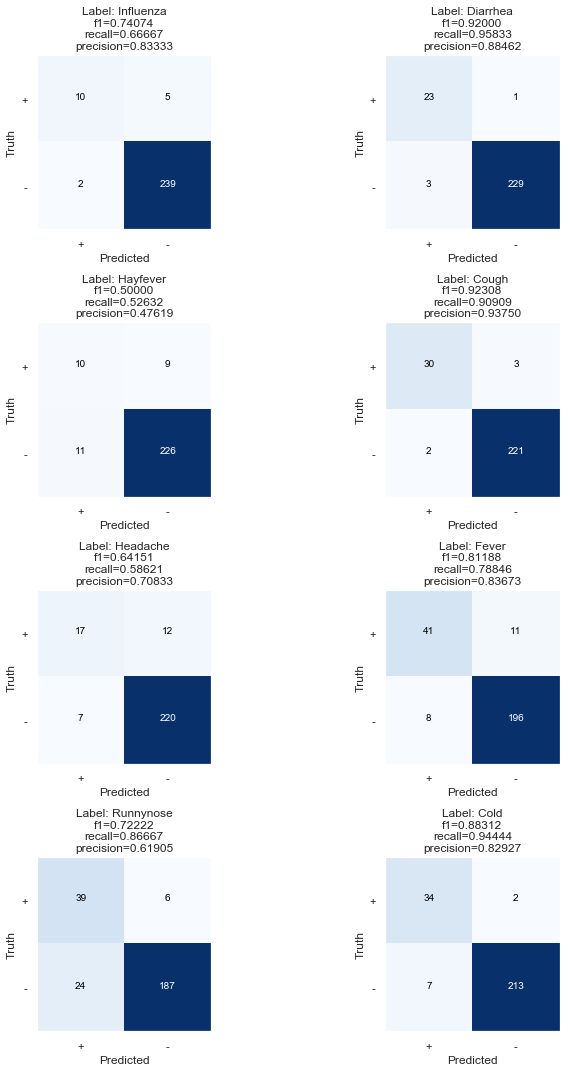

In [32]:
def plot_confusion_matrix(cm, classes, title, ax):

    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks), ax.xaxis.set_ticklabels(classes)
    ax.set_yticks(tick_marks), ax.yaxis.set_ticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    ax.set_title(title)
    ax.grid(False)
    
def plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False):
    fig, axes = plt.subplots(int(np.ceil(len(label_to_class) / 2)), 2, figsize=(15, 15))
    axes = axes.flatten()
    for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true, y_pred)):
        tn, fp, fn, tp = conf_matrix.ravel()
        f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
        recall = tp / (tp + fn + sys.float_info.epsilon)
        precision = tp / (tp + fp + sys.float_info.epsilon)
        plot_confusion_matrix(
            np.array([[tp, fn], [fp, tn]]),
            classes=['+', '-'],
            title=f'Label: {label_to_class[i]}\nf1={f1:.5f}\nrecall={recall:.5f}\nprecision={precision:.5f}',
            ax=axes[i]
        )
        plt.tight_layout()
    if save_plot:
        plt.savefig('confusion_matrices.png', dpi=50)
        
plot_multiclass_confusion_matrix(y_test, y_pred, categories)

In [33]:
print(classification_report(y_test.values, y_pred, target_names=categories))

              precision    recall  f1-score   support

   Influenza       0.83      0.67      0.74        15
    Diarrhea       0.88      0.96      0.92        24
    Hayfever       0.48      0.53      0.50        19
       Cough       0.94      0.91      0.92        33
    Headache       0.71      0.59      0.64        29
       Fever       0.84      0.79      0.81        52
   Runnynose       0.62      0.87      0.72        45
        Cold       0.83      0.94      0.88        36

   micro avg       0.76      0.81      0.78       253
   macro avg       0.77      0.78      0.77       253
weighted avg       0.77      0.81      0.78       253
 samples avg       0.61      0.59      0.59       253



In [34]:
print("Hamming_loss:", hamming_loss(y_test.values, y_pred))

Hamming_loss: 0.05517578125


In [35]:
print(X_test[0])

[ 61   3 966   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


In [36]:
for i in range(5):
    predictions = model.predict(np.expand_dims(X_test[i], 0))
    print((y_test.iloc[i].values == predictions.round()[0]).all())
    print("Text:", tokenizer.sequences_to_texts([X_test[i]])[0])
    print("Truth:", y_test.iloc[i].values)
    print("Predicted:", predictions.round()[0].astype(int))
    print("\n")

True
Text: bird flu horrifi
Truth: [0 0 0 0 0 0 0 0]
Predicted: [0 0 0 0 0 0 0 0]


False
Text: given headach medicin not work all
Truth: [0 0 0 0 1 0 0 0]
Predicted: [0 0 1 0 0 0 1 0]


True
Text: cough day exhaust
Truth: [0 0 0 1 0 0 0 0]
Predicted: [0 0 0 1 0 0 0 0]


True
Text: got fever wonder caught diseas
Truth: [0 0 0 0 0 1 0 0]
Predicted: [0 0 0 0 0 1 0 0]


False
Text: got flu shot
Truth: [1 0 0 0 0 1 0 0]
Predicted: [0 0 0 0 0 0 0 0]


